In [1]:
import tensorflow as tf
from tensorflow import keras
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 1. #what portion of gpu to use
session = tf.Session(config=config)
keras.backend.set_session(session)

In [2]:
from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Add, Lambda, add
from keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, concatenate
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D, Conv2DTranspose, MaxPooling2D
from keras.models import Sequential, Model
from keras.optimizers import Adam, RMSprop
from tensorflow.examples.tutorials.mnist import input_data
from skimage.io import imread

import matplotlib.pyplot as plt

import numpy as np

Using TensorFlow backend.


In [8]:
from keras.backend import resize_images
from skimage.transform import resize

In [9]:
from pathlib import Path

classes = ['BUBBLES_v3','CLEAR_BLOB','DILATED','TURBID_v2','UNDEFINED','WALL','WRINKLES_v2']
#classes = ['BUBBLES_v3','CLEAR_BLOB','DILATED','UNDEFINED','WALL','WRINKLES_v2']
mainDir = '../../data/intestins/original/'

In [10]:
img_per_class = 2500
img_per_test = 10
cls = 0
data = {}
X_train = np.empty([7*img_per_class,64,64,3])
y_train = np.zeros([7*img_per_class])
X_test = np.empty([7*img_per_test,64,64,3])
y_test = np.zeros([7*img_per_test])
for c in classes:
    cnt = 0
    data[cls] = np.empty([img_per_class+img_per_test,64,64,3])
    curDir = mainDir + c
    pathlist = Path(curDir).glob('*')
    for path in pathlist:
        path_str = str(path)
        if "png" not in path_str and "jpg" not in path_str and "bmp" not in path_str:
            continue
        if "r180" in path_str or "r90" in path_str:
            continue
        im = imread(path_str)
        imarray = np.array(im)
        imresized = resize(imarray, (64,64), mode='symmetric')
        if cnt >= img_per_class + img_per_test:
            break
        elif cnt >= img_per_class:
            X_test[cls * img_per_test + cnt - img_per_class] = imresized
            y_test[cls * img_per_test + cnt - img_per_class] = cls
        else:
            X_train[cls * img_per_class + cnt] = imresized
            y_train[cls * img_per_class + cnt] = cls
        data[cls][cnt] = imresized
        cnt += 1
    cls += 1

/opt/anaconda/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Show some samples of the real images:

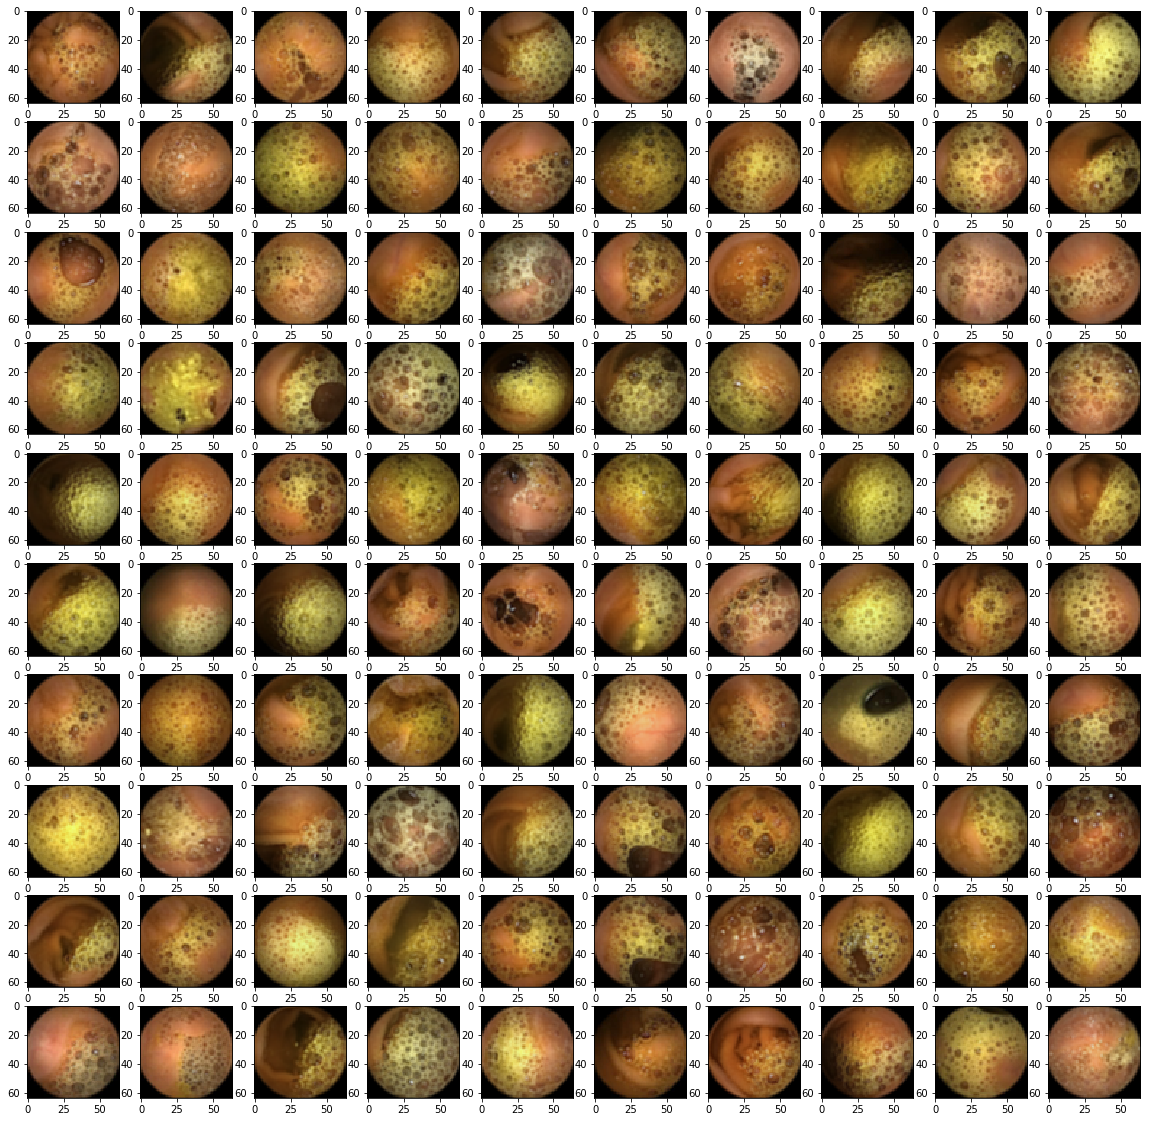

In [11]:
fig, axs = plt.subplots(10, 10,figsize=(20, 20))
cnt = 120
for i in range(10):
    for j in range(10):
        axs[i,j].imshow(X_train[cnt])
        cnt += 1
plt.show()
plt.close()

**The network for 64x64 images**

In [13]:
# Based on code by Hanling Wang (2018-11-21)
# https://github.com/kongyanye/cwgan-gp/blob/master/cwgan_gp.py
# who further credits:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py and
# https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import math

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        global batch_size
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
        
class CWGANGP():
    def __init__(self, epochs=100, batch_size=32, sample_interval=50):
        self.img_rows = 64
        self.img_cols = 64
        self.channels = 3
        self.nclasses = 7
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.losslog = []
        self.epochs = epochs
        self.batch_size = batch_size
        self.sample_interval = sample_interval
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        
        # Generate image based of noise (fake sample) and add label to the input 
        label = Input(shape=(1,))
        fake_img = self.generator([z_disc, label])

        # Discriminator determines validity of the real and fake images
        fake = self.critic([fake_img, label])
        valid = self.critic([real_img, label])

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        
        # Determine validity of weighted sample
        validity_interpolated = self.critic([interpolated_img, label])

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, label, z_disc], outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # add label to the input
        label = Input(shape=(1,))
        # Generate images based of noise
        img = self.generator([z_gen, label])
        # Discriminator determines validity
        valid = self.critic([img, label])
        # Defines generator model
        self.generator_model = Model([z_gen, label], valid)
        self.generator_model.compile(loss=self.wasserstein_loss, optimizer=optimizer)
        
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):

        dropout = 0.4
        depth = 256
        dim = 8
        
        noise = Input(shape=(self.latent_dim,))    
        label = Input(shape=(1,))   
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        model_input = concatenate([noise, label_embedding])
        
        # In: 100
        # Out: dim x dim x depth
        d = Dense(dim*dim*depth, activation="relu")(model_input)
        d = BatchNormalization(momentum=0.9)(d)
        d = Reshape((dim, dim, depth))(d) # 8 x 8 x 256

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        u1 = UpSampling2D()(d) # 16 x 16 x 256
        
        c1 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(u1) # 16 x 16 x 128
        c1 = BatchNormalization(momentum=0.9)(c1)
        
        c2 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c1) # 16 x 16 x 128
        c2 = BatchNormalization(momentum=0.9)(c2)
        
        c3 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c2) # 16 x 16 x 128
        c3 = BatchNormalization(momentum=0.9)(c3)
        
        c4 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c3) # 16 x 16 x 128
        c4 = BatchNormalization(momentum=0.9)(c4)
        
        a1 = Add()([c1, c4])
        u2 = UpSampling2D()(a1) # 32 x 32 x 128
        
        c5 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(u2) # 32 x 32 x 64
        c5 = BatchNormalization(momentum=0.9)(c5)
        
        c6 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c5) # 32 x 32 x 64
        c6 = BatchNormalization(momentum=0.9)(c6)
        
        c7 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c6) # 32 x 32 x 64
        c7 = BatchNormalization(momentum=0.9)(c7)
        
        c8 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c7) # 32 x 32 x 64
        c8 = BatchNormalization(momentum=0.9)(c8)
        
        a2 = Add()([c5, c8])
        u3 = UpSampling2D()(a2) # 64 x 64 x 64
        
        c9 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(u3) # 64 x 64 x 32
        c9 = BatchNormalization(momentum=0.9)(c9)
        
        c10 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c9) # 64 x 64 x 32
        c10 = BatchNormalization(momentum=0.9)(c10)
        
        c11 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c10) # 64 x 64 x 32
        c11 = BatchNormalization(momentum=0.9)(c11)
        
        c12 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c11) # 64 x 64 x 32
        c12 = BatchNormalization(momentum=0.9)(c12)
        
        a3 = Add()([c9, c12])

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        generated_img = Conv2DTranspose(3, 5, padding='same')(a3) # 64 x 64 x 3
        
        model = Model(inputs = [noise, label], output = generated_img) 
        model.summary()
        return model

    def build_critic(self):

        depth = 64
        dropout = 0.2
        
        img = Input(shape=self.img_shape)
        
        label = Input(shape=(1,))
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        d1 = Dense(512, activation="relu")(label_embedding)
        d2 = Dense(4096, activation="relu")(d1)
        label_img_shape = Reshape((64,64,1))(d2)
        
        new_img = concatenate([img, label_img_shape], axis=3)
        
        c1 = Conv2D(depth, 5, strides=2, padding='same')(new_img)
        c1 = LeakyReLU(alpha=0.2)(c1)
        c1 = Dropout(dropout)(c1) # 32 x 32 x 64
        
        c2 = Conv2D(depth, 5, padding='same')(c1)
        c2 = LeakyReLU(alpha=0.2)(c2)
        c2 = Dropout(dropout)(c2) # 32 x 32 x 64
        
        c3 = Conv2D(depth, 5, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c3)
        c3 = Dropout(dropout)(c3) # 32 x 32 x 64
        
        c4 = Conv2D(depth, 5, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c4)
        c4 = Dropout(dropout)(c4) # 32 x 32 x 64
        
        a1 = Add()([c1, c4])
           
        c5 = Conv2D(depth*2, 5, strides=2, padding='same')(a1)
        c5 = LeakyReLU(alpha=0.2)(c5)
        c5 = Dropout(dropout)(c5) # 16 x 16 x 128
        
        c6 = Conv2D(depth*2, 5, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        c6 = Dropout(dropout)(c6) # 16 x 16 x 128
        
        c7 = Conv2D(depth*2, 5, padding='same')(c6)
        c7 = LeakyReLU(alpha=0.2)(c7)
        c7 = Dropout(dropout)(c7) # 16 x 16 x 128
        
        c8 = Conv2D(depth*2, 5, padding='same')(c7)
        c8 = LeakyReLU(alpha=0.2)(c8)
        c8 = Dropout(dropout)(c8) # 16 x 16 x 128
        
        a2 = Add()([c5, c8])
        
        c9 = Conv2D(depth*4, 5, strides=2, padding='same')(a2)
        c9 = LeakyReLU(alpha=0.2)(c9)
        c9 = Dropout(dropout)(c9) # 8 x 8 x 256
        
        c10 = Conv2D(depth*4, 5, padding='same')(c9)
        c10 = LeakyReLU(alpha=0.2)(c10)
        c10 = Dropout(dropout)(c10) # 8 x 8 x 256
        
        c11 = Conv2D(depth*4, 5, padding='same')(c10)
        c11 = LeakyReLU(alpha=0.2)(c11)
        c11 = Dropout(dropout)(c11) # 8 x 8 x 256
        
        c12 = Conv2D(depth*4, 5, padding='same')(c11)
        c12 = LeakyReLU(alpha=0.2)(c12)
        c12 = Dropout(dropout)(c12) # 8 x 8 x 256
        
        a3 = Add()([c9, c12])
        
        c13 = Conv2D(depth*8, 5, strides=2, padding='same')(a3)
        c13 = LeakyReLU(alpha=0.2)(c13) # 4 x 4 x 512

        f = Flatten()(c13)
        
        validity = Dense(1)(f)
        
        model = Model(inputs=[img,label], output=validity)
        model.summary()
        return model

    def train(self, X_train, y_train):

        # Adversarial ground truths
        valid = -np.ones((self.batch_size, 1))
        fake =  np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1)) # Dummy gt for gradient penalty
        for epoch in range(self.epochs):
            
            idx = np.random.permutation(X_train.shape[0])
            X_train = X_train[idx]
            y_train = y_train[idx]
            
            steps = math.ceil(X_train.shape[0]/batch_size)
            
            for step in range(steps):

                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                imgs = X_train[step*self.batch_size:min((step+1)*self.batch_size,X_train.shape[0])]
                labels = y_train[step*self.batch_size:min((step+1)*self.batch_size,X_train.shape[0])]
                # Sample generator input
                noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, labels, noise], [valid, fake, dummy])
                
                # ---------------------
                #  Train Generator
                # ---------------------
                
                if step % self.n_critic == 0:
                
                    sampled_labels = np.random.randint(0, self.nclasses, self.batch_size).reshape(-1, 1)
                    g_loss = self.generator_model.train_on_batch([noise, sampled_labels], valid)

            # Plot the progress
            print ("%d [D loss: %f] [G loss: %f]" % (epoch, d_loss[0], g_loss))
            self.losslog.append([d_loss[0], g_loss])
            
            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0:
                self.sample_images(epoch)
                self.generator.save_weights('generator', overwrite=True)
                self.critic.save_weights('discriminator', overwrite=True)
                with open('loss.log', 'w') as f:
                    f.writelines('d_loss, g_loss\n')
                    for each in self.losslog:
                        f.writelines('%s, %s\n'%(each[0], each[1]))

    def sample_images(self, epoch):
        r, c = 10, 7
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.array(list(range(7))*10).reshape(-1, 1)
        
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = self.combine_images(gen_imgs)

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure(figsize=(20,20))
        plt.imshow(gen_imgs)
        plt.axis('off')
        plt.savefig("images/mnist_%d.png" % epoch)
        plt.close()
    
    def combine_images(self, generated_images):
        num = generated_images.shape[0]
        width = 10
        height = 7
        shape = generated_images.shape[1:3]
        image = np.zeros((height*shape[0], width*shape[1], 3),
                         dtype=generated_images.dtype)
        for index, img in enumerate(generated_images):
            i = int(index/width)
            j = index % width
            image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
                img[:, :, :]
        return image
    
    def generate_images(self, label):
        self.generator.load_weights('../cwgan_gp/generator')
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict([noise, np.array(label).reshape(-1,1)])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 0.5
        
        plt.imshow(gen_imgs[0,:,:,:])
        plt.axis('off')

        plt.close()

if __name__ == '__main__':
    epochs = 2000
    batch_size = 100
    sample_interval = 20
    wgan = CWGANGP(epochs, batch_size, sample_interval)
    wgan.train(X_train, y_train)
    # wgan.generate_images(1) # generate images of a specific class

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:207: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("co...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 100)       700         input_2[0][0]                    
__________________________________________________________________________________________________
input_1 (InputLayer)            (None, 100)          0                                            
__________________________________________________________________________________________________
flatten_1 (Flatten)             (None, 100)          0           embedding_1[0][0]                
__________________________________________________________________________________________________
concatenat

/opt/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:287: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 1)            0                                            
__________________________________________________________________________________________________
embedding_2 (Embedding)         (None, 1, 100)       700         input_4[0][0]                    
__________________________________________________________________________________________________
flatten_2 (Flatten)             (None, 100)          0           embedding_2[0][0]                
__________________________________________________________________________________________________
dense_2 (Dense)                 (None, 512)          51712       flatten_2[0][0]                  
__________________________________________________________________________________________________
dense_3 (D

/opt/anaconda/lib/python3.6/site-packages/keras/engine/training.py:479: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


ResourceExhaustedError: OOM when allocating tensor of shape [] and type float
	 [[{{node training/RMSprop/gradients/zeros_41/Const}} = Const[_class=["loc:@training/RMSprop/gradients/AddN_57"], dtype=DT_FLOAT, value=Tensor<type: float shape: [] values: 0>, _device="/job:localhost/replica:0/task:0/device:GPU:0"](^training/RMSprop/gradients/Identity_41)]]

**The network for 128x128 images**

In [ ]:
# Based on code by Hanling Wang (2018-11-21)
# who further credits:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py and
# https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import math

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        global batch_size
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
        
class CWGANGP():
    def __init__(self, epochs=100, batch_size=32, sample_interval=50):
        self.img_rows = 128
        self.img_cols = 128
        self.channels = 3
        self.nclasses = 7
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.losslog = []
        self.epochs = epochs
        self.batch_size = batch_size
        self.sample_interval = sample_interval
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()
        
        # Build and compile the classifier
        self.classifier = self.build_classifier()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        
        # Generate image based of noise (fake sample) and add label to the input 
        label = Input(shape=(1,))
        fake_img = self.generator([z_disc, label])

        # Discriminator determines validity of the real and fake images
        fake = self.critic([fake_img, label])
        valid = self.critic([real_img, label])

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        
        # Determine validity of weighted sample
        validity_interpolated = self.critic([interpolated_img, label])

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, label, z_disc], outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True
        self.classifier.trainable = False

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # add label to the input
        label = Input(shape=(1,))
        # Generate images based of noise
        img = self.generator([z_gen, label])
        # Discriminator determines validity
        valid = self.critic([img, label])
        # Classify fake images
        classified = self.classifier([img])
        # Defines generator model
        self.generator_model = Model([z_gen, label], [valid, classified])
        self.generator_model.compile(loss=[self.wasserstein_loss, 'categorical_crossentropy'], optimizer=optimizer)
        
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_classifier(self):

        model = Sequential()
        model.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(7, activation="softmax"))
        return model

    def build_generator(self):

        dropout = 0.4
        depth = 256
        dim = 8
        
        noise = Input(shape=(self.latent_dim,))    
        label = Input(shape=(1,))   
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        model_input = concatenate([noise, label_embedding])
        
        # In: 100
        # Out: dim x dim x depth
        d = Dense(dim*dim*depth, activation="relu")(model_input)
        d = BatchNormalization(momentum=0.9)(d)
        d = Reshape((dim, dim, depth))(d) # 8 x 8 x 256

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        
        u1 = UpSampling2D()(d) # 16 x 16 x 256
        
        c1 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(u1) # 16 x 16 x 128
        c1 = BatchNormalization(momentum=0.9)(c1)
        
        c2 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c1) # 16 x 16 x 128
        c2 = BatchNormalization(momentum=0.9)(c2)
        
        c3 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c2) # 16 x 16 x 128
        c3 = BatchNormalization(momentum=0.9)(c3)
        
        c4 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c3) # 16 x 16 x 128
        c4 = BatchNormalization(momentum=0.9)(c4)
        
        a1 = Add()([c1, c4])
        u2 = UpSampling2D()(a1) # 32 x 32 x 128
        
        c5 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(u2) # 32 x 32 x 64
        c5 = BatchNormalization(momentum=0.9)(c5)
        
        c6 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c5) # 32 x 32 x 64
        c6 = BatchNormalization(momentum=0.9)(c6)
        
        c7 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c6) # 32 x 32 x 64
        c7 = BatchNormalization(momentum=0.9)(c7)
        
        c8 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c7) # 32 x 32 x 64
        c8 = BatchNormalization(momentum=0.9)(c8)
        
        a2 = Add()([c5, c8])
        u3 = UpSampling2D()(a2) # 64 x 64 x 64
        
        c9 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(u3) # 64 x 64 x 32
        c9 = BatchNormalization(momentum=0.9)(c9)
        
        c10 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c9) # 64 x 64 x 32
        c10 = BatchNormalization(momentum=0.9)(c10)
        
        c11 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c10) # 64 x 64 x 32
        c11 = BatchNormalization(momentum=0.9)(c11)
        
        c12 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c11) # 64 x 64 x 32
        c12 = BatchNormalization(momentum=0.9)(c12)
        
        a3 = Add()([c9, c12])
        u4 = UpSampling2D()(a3) # 128 x 128 x 32
        
        c13 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(u4) # 128 x 128 x 16
        c13 = BatchNormalization(momentum=0.9)(c13)
        
        c14 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(c13) # 128 x 128 x 16
        c14 = BatchNormalization(momentum=0.9)(c14)
        
        c15 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(c14) # 128 x 128 x 16
        c15 = BatchNormalization(momentum=0.9)(c15)
        
        c16 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(c15) # 128 x 128 x 16
        c16 = BatchNormalization(momentum=0.9)(c16)
        
        a4 = Add()([c13, c16])

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        generated_img = Conv2DTranspose(3, 5, padding='same')(a4) # 64 x 64 x 3
        
        model = Model(inputs = [noise, label], output = generated_img) 
        model.summary()
        return model

    def build_critic(self):
        
        depth = 32
        dropout = 0.2

        img = Input(shape=self.img_shape)
        flat_img = Flatten()(img)
        
        label = Input(shape=(1,))
        label_embedding = Flatten()(Embedding(self.nclasses, np.prod(self.img_shape))(label))
        
        model_img = multiply([flat_img, label_embedding])
        model_img = Reshape(self.img_shape)(model_img)
        
        c1 = Conv2D(depth, 5, strides=2, padding='same')(model_img)
        c1 = LeakyReLU(alpha=0.2)(c1)
        #c1 = Dropout(dropout)(c1) # 64 x 64 x 32
        
        c2 = Conv2D(depth, 5, padding='same')(c1)
        c2 = LeakyReLU(alpha=0.2)(c2)
        #c2 = Dropout(dropout)(c2) # 64 x 64 x 32
        
        c3 = Conv2D(depth, 5, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c3)
        #c3 = Dropout(dropout)(c3) # 64 x 64 x 32
        
        c4 = Conv2D(depth, 5, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c4)
        #c4 = Dropout(dropout)(c4) # 64 x 64 x 32
        
        a1 = Add()([c1, c4])
           
        c5 = Conv2D(depth*2, 5, strides=2, padding='same')(a1)
        c5 = LeakyReLU(alpha=0.2)(c5)
        #c5 = Dropout(dropout)(c5) # 32 x 32 x 64
        
        c6 = Conv2D(depth*2, 5, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        #c6 = Dropout(dropout)(c6) # 32 x 32 x 64
        
        c7 = Conv2D(depth*2, 5, padding='same')(c6)
        c7 = LeakyReLU(alpha=0.2)(c7)
        #c7 = Dropout(dropout)(c7) # 32 x 32 x 64
        
        c8 = Conv2D(depth*2, 5, padding='same')(c7)
        c8 = LeakyReLU(alpha=0.2)(c8)
        #c8 = Dropout(dropout)(c8) # 32 x 32 x 64
        
        a2 = Add()([c5, c8])
        
        c9 = Conv2D(depth*4, 5, strides=2, padding='same')(a2)
        c9 = LeakyReLU(alpha=0.2)(c9)
        #c9 = Dropout(dropout)(c9) # 16 x 16 x 128
        
        c10 = Conv2D(depth*4, 5, padding='same')(c9)
        c10 = LeakyReLU(alpha=0.2)(c10)
        #c10 = Dropout(dropout)(c10) # 16 x 16 x 128
        
        c11 = Conv2D(depth*4, 5, padding='same')(c10)
        c11 = LeakyReLU(alpha=0.2)(c11)
        #c11 = Dropout(dropout)(c11) # 16 x 16 x 128
        
        c12 = Conv2D(depth*4, 5, padding='same')(c11)
        c12 = LeakyReLU(alpha=0.2)(c12)
        #c12 = Dropout(dropout)(c12) # 16 x 16 x 128
        
        a3 = Add()([c9, c12])
        
        c13 = Conv2D(depth*4, 5, strides=2, padding='same')(a3)
        c13 = LeakyReLU(alpha=0.2)(c13) # 8 x 8 x 256
        
        c14 = Conv2D(depth*4, 5, padding='same')(c13)
        c14 = LeakyReLU(alpha=0.2)(c14) # 8 x 8 x 256
        
        c15 = Conv2D(depth*4, 5, padding='same')(c14)
        c15 = LeakyReLU(alpha=0.2)(c15) # 8 x 8 x 256
        
        c16 = Conv2D(depth*4, 5, padding='same')(c15)
        c16 = LeakyReLU(alpha=0.2)(c16) # 8 x 8 x 256
        
        a4 = Add()([c13, c16])
        
        c17 = Conv2D(depth*8, 5, strides=2, padding='same')(a4)
        c17 = LeakyReLU(alpha=0.2)(c17) # 4 x 4 x 512

        f = Flatten()(c17)
        validity = Dense(1)(f)
        
        model = Model(inputs=[img,label], output=validity)
        model.summary()
        return model
    
    def train_classifier(self, X_train, y_train):
        
        y_train_one_hot = to_categorical(y_train, 7)
        
        # Train the classifier
        self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.classifier.fit(X_train, y_train_one_hot, batch_size=100, epochs=50, verbose=1)
    

    def train(self, X_train, y_train):

        # Adversarial ground truths
        valid = -np.ones((self.batch_size, 1))
        fake =  np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1)) # Dummy gt for gradient penalty
        
        # set up tensorboard
        writer = tf.summary.FileWriter('./logs')
        writer_hist = tf.summary.FileWriter('./hists')
        
        g_loss = None
        d_loss = None
        
        summary = tf.Summary()
        summary.value.add(tag='generator', simple_value=g_loss)
        summary.value.add(tag='discriminator', simple_value=d_loss)
        
        
        for epoch in range(self.epochs):
            for _ in range(self.n_critic):
                
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], self.batch_size)
                imgs, labels = X_train[idx], y_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, labels, noise], [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------
            sampled_labels = np.random.randint(0, self.nclasses, self.batch_size).reshape(-1, 1)
            labels_one_hot = to_categorical(sampled_labels, 7)
            g_loss = self.generator_model.train_on_batch([noise, sampled_labels], [valid, labels_one_hot])

            # Add results to tensorboard
            summary.value[0].simple_value = g_loss[0]
            summary.value[1].simple_value = d_loss[0]
            writer.add_summary(summary, epoch)
            
            #d_pred = self.critic_model.predict_on_batch([imgs, labels, noise])
            #log_histogram(writer_hist, 'discriminator_preds', d_pred, epoch, bins=1000)
            
            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0:
                self.sample_images(epoch)
                self.generator.save_weights('generator', overwrite=True)
                self.critic.save_weights('discriminator', overwrite=True)
                with open('loss.log', 'w') as f:
                    f.writelines('d_loss, g_loss\n')
                    for each in self.losslog:
                        f.writelines('%s, %s\n'%(each[0], each[1]))

    def sample_images(self, epoch):
        r, c = 10, 7
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.array(list(range(7))*10).reshape(-1, 1)
        
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = self.combine_images(gen_imgs)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure(figsize=(20, 14))
        plt.imshow(gen_imgs)
        plt.axis('off')
        plt.savefig("images_highres/intestines_%d.png" % epoch)
        plt.close()
    
    def combine_images(self, generated_images):
        num = generated_images.shape[0]
        width = 10
        height = 7
        shape = generated_images.shape[1:3]
        image = np.zeros((width*shape[0], height*shape[1], 3),
                         dtype=generated_images.dtype)
        for index, img in enumerate(generated_images):
            j = int(index/width)
            i = index % width
            image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
                img[:, :, :]
        return image
    
    def generate_images(self, label):
        self.generator.load_weights('../cwgan_gp/generator')
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict([noise, np.array(label).reshape(-1,1)])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1
        
        plt.imshow(gen_imgs[0,:,:,0], cmap='gray')
        plt.axis('off')

        plt.close()

if __name__ == '__main__':
    epochs = 50000
    batch_size = 32
    sample_interval = 1000
    wgan = CWGANGP(epochs, batch_size, sample_interval)
    wgan.train_classifier(X_train, y_train)
    wgan.train(X_train, y_train)
    # wgan.generate_images(1) # generate images of a specific class

**The network for 256x256 images**

In [ ]:
# Based on code by Hanling Wang (2018-11-21)
# who further credits:
# https://github.com/eriklindernoren/Keras-GAN/blob/master/wgan_gp/wgan_gp.py and
# https://github.com/eriklindernoren/Keras-GAN/blob/master/cgan/cgan.py

from __future__ import print_function, division

from keras.datasets import mnist
from keras.layers.merge import _Merge
from keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, Embedding
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Sequential, Model
from keras.optimizers import RMSprop
from functools import partial

import keras.backend as K

import matplotlib.pyplot as plt

import math

import numpy as np

class RandomWeightedAverage(_Merge):
    """Provides a (random) weighted average between real and generated image samples"""
    def _merge_function(self, inputs):
        global batch_size
        alpha = K.random_uniform((batch_size, 1, 1, 1))
        return (alpha * inputs[0]) + ((1 - alpha) * inputs[1])
        
class CWGANGP():
    def __init__(self, epochs=100, batch_size=32, sample_interval=50):
        self.img_rows = 256
        self.img_cols = 256
        self.channels = 3
        self.nclasses = 7
        self.img_shape = (self.img_rows, self.img_cols, self.channels)
        self.latent_dim = 100
        self.losslog = []
        self.epochs = epochs
        self.batch_size = batch_size
        self.sample_interval = sample_interval
        
        # Following parameter and optimizer set as recommended in paper
        self.n_critic = 5
        optimizer = RMSprop(lr=0.00005)

        # Build the generator and critic
        self.generator = self.build_generator()
        self.critic = self.build_critic()
        
        # Build and compile the classifier
        self.classifier = self.build_classifier()

        #-------------------------------
        # Construct Computational Graph
        #       for the Critic
        #-------------------------------

        # Freeze generator's layers while training critic
        self.generator.trainable = False

        # Image input (real sample)
        real_img = Input(shape=self.img_shape)

        # Noise input
        z_disc = Input(shape=(self.latent_dim,))
        
        # Generate image based of noise (fake sample) and add label to the input 
        label = Input(shape=(1,))
        fake_img = self.generator([z_disc, label])

        # Discriminator determines validity of the real and fake images
        fake = self.critic([fake_img, label])
        valid = self.critic([real_img, label])

        # Construct weighted average between real and fake images
        interpolated_img = RandomWeightedAverage()([real_img, fake_img])
        
        # Determine validity of weighted sample
        validity_interpolated = self.critic([interpolated_img, label])

        # Use Python partial to provide loss function with additional
        # 'averaged_samples' argument
        partial_gp_loss = partial(self.gradient_penalty_loss,
                          averaged_samples=interpolated_img)
        partial_gp_loss.__name__ = 'gradient_penalty' # Keras requires function names

        self.critic_model = Model(inputs=[real_img, label, z_disc], outputs=[valid, fake, validity_interpolated])
        self.critic_model.compile(loss=[self.wasserstein_loss,
                                        self.wasserstein_loss,
                                        partial_gp_loss],
                                        optimizer=optimizer,
                                        loss_weights=[1, 1, 10])
        #-------------------------------
        # Construct Computational Graph
        #         for Generator
        #-------------------------------

        # For the generator we freeze the critic's layers
        self.critic.trainable = False
        self.generator.trainable = True
        self.classifier.trainable = False

        # Sampled noise for input to generator
        z_gen = Input(shape=(100,))
        # add label to the input
        label = Input(shape=(1,))
        # Generate images based of noise
        img = self.generator([z_gen, label])
        # Discriminator determines validity
        valid = self.critic([img, label])
        # Classify fake images
        classified = self.classifier([img])
        # Defines generator model
        self.generator_model = Model([z_gen, label], [valid, classified])
        self.generator_model.compile(loss=[self.wasserstein_loss, 'categorical_crossentropy'], optimizer=optimizer)
        
        
    def gradient_penalty_loss(self, y_true, y_pred, averaged_samples):
        """
        Computes gradient penalty based on prediction and weighted real / fake samples
        """
        gradients = K.gradients(y_pred, averaged_samples)[0]
        # compute the euclidean norm by squaring ...
        gradients_sqr = K.square(gradients)
        #   ... summing over the rows ...
        gradients_sqr_sum = K.sum(gradients_sqr,
                                  axis=np.arange(1, len(gradients_sqr.shape)))
        #   ... and sqrt
        gradient_l2_norm = K.sqrt(gradients_sqr_sum)
        # compute lambda * (1 - ||grad||)^2 still for each single sample
        gradient_penalty = K.square(1 - gradient_l2_norm)
        # return the mean as loss over all the batch samples
        return K.mean(gradient_penalty)


    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)
    
    def build_classifier(self):

        model = Sequential()
        model.add(Conv2D(16, kernel_size=3, strides=2, padding="same"))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(32, kernel_size=3, strides=2, padding="same"))
        model.add(ZeroPadding2D(padding=((0,1),(0,1))))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
        model.add(BatchNormalization(momentum=0.8))
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.25))
        model.add(Flatten())
        model.add(Dense(7, activation="softmax"))
        return model

    def build_generator(self):

        dropout = 0.4
        depth = 256
        dim = 8
        
        noise = Input(shape=(self.latent_dim,))    
        label = Input(shape=(1,))   
        label_embedding = Flatten()(Embedding(self.nclasses, self.latent_dim)(label))
        model_input = concatenate([noise, label_embedding])
        
        # In: 100
        # Out: dim x dim x depth
        d = Dense(dim*dim*depth, activation="relu")(model_input)
        d = BatchNormalization(momentum=0.9)(d)
        d = Reshape((dim, dim, depth))(d) # 8 x 8 x 256

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        
        u1 = UpSampling2D()(d) # 16 x 16 x 256
        
        c1 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(u1) # 16 x 16 x 128
        c1 = BatchNormalization(momentum=0.9)(c1)
        
        c2 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c1) # 16 x 16 x 128
        c2 = BatchNormalization(momentum=0.9)(c2)
        
        c3 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c2) # 16 x 16 x 128
        c3 = BatchNormalization(momentum=0.9)(c3)
        
        c4 = Conv2DTranspose(int(depth/2), 5, padding='same', activation="relu")(c3) # 16 x 16 x 128
        c4 = BatchNormalization(momentum=0.9)(c4)
        
        a1 = Add()([c1, c4])
        u2 = UpSampling2D()(a1) # 32 x 32 x 128
        
        c5 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(u2) # 32 x 32 x 64
        c5 = BatchNormalization(momentum=0.9)(c5)
        
        c6 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c5) # 32 x 32 x 64
        c6 = BatchNormalization(momentum=0.9)(c6)
        
        c7 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c6) # 32 x 32 x 64
        c7 = BatchNormalization(momentum=0.9)(c7)
        
        c8 = Conv2DTranspose(int(depth/4), 5, padding='same', activation="relu")(c7) # 32 x 32 x 64
        c8 = BatchNormalization(momentum=0.9)(c8)
        
        a2 = Add()([c5, c8])
        u3 = UpSampling2D()(a2) # 64 x 64 x 64
        
        c9 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(u3) # 64 x 64 x 32
        c9 = BatchNormalization(momentum=0.9)(c9)
        
        c10 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c9) # 64 x 64 x 32
        c10 = BatchNormalization(momentum=0.9)(c10)
        
        c11 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c10) # 64 x 64 x 32
        c11 = BatchNormalization(momentum=0.9)(c11)
        
        c12 = Conv2DTranspose(int(depth/8), 5, padding='same', activation="relu")(c11) # 64 x 64 x 32
        c12 = BatchNormalization(momentum=0.9)(c12)
        
        a3 = Add()([c9, c12])
        u4 = UpSampling2D()(a3) # 128 x 128 x 32
        
        c13 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(u4) # 128 x 128 x 16
        c13 = BatchNormalization(momentum=0.9)(c13)
        
        c14 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(c13) # 128 x 128 x 16
        c14 = BatchNormalization(momentum=0.9)(c14)
        
        c15 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(c14) # 128 x 128 x 16
        c15 = BatchNormalization(momentum=0.9)(c15)
        
        c16 = Conv2DTranspose(int(depth/16), 5, padding='same', activation="relu")(c15) # 128 x 128 x 16
        c16 = BatchNormalization(momentum=0.9)(c16)
        
        a4 = Add()([c13, c16])
        u5 = UpSampling2D()(a4) # 256 x 256 x 16
        
        c17 = Conv2DTranspose(int(depth/32), 5, padding='same', activation="relu")(u5) # 256 x 256 x 8
        c17 = BatchNormalization(momentum=0.9)(c17)
        
        c18 = Conv2DTranspose(int(depth/32), 5, padding='same', activation="relu")(c17) # 256 x 256 x 8
        c18 = BatchNormalization(momentum=0.9)(c18)
        
        c19 = Conv2DTranspose(int(depth/32), 5, padding='same', activation="relu")(c18) # 256 x 256 x 8
        c19 = BatchNormalization(momentum=0.9)(c19)
        
        c20 = Conv2DTranspose(int(depth/32), 5, padding='same', activation="relu")(c19) # 256 x 256 x 8
        c20 = BatchNormalization(momentum=0.9)(c20)
        
        a5 = Add()([c17, c20])

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        generated_img = Conv2DTranspose(3, 5, padding='same')(a5) # 256 x 256 x 3
        
        model = Model(inputs = [noise, label], output = generated_img) 
        model.summary()
        return model

    def build_critic(self):
        
        depth = 16
        dropout = 0.2

        img = Input(shape=self.img_shape)
        flat_img = Flatten()(img)
        
        label = Input(shape=(1,))
        label_embedding = Flatten()(Embedding(self.nclasses, np.prod(self.img_shape))(label))
        
        model_img = multiply([flat_img, label_embedding])
        model_img = Reshape(self.img_shape)(model_img)
        
        c1 = Conv2D(depth, 5, strides=2, padding='same')(model_img)
        c1 = LeakyReLU(alpha=0.2)(c1)
        #c1 = Dropout(dropout)(c1) # 64 x 64 x 32
        
        c2 = Conv2D(depth, 5, padding='same')(c1)
        c2 = LeakyReLU(alpha=0.2)(c2)
        #c2 = Dropout(dropout)(c2) # 64 x 64 x 32
        
        c3 = Conv2D(depth, 5, padding='same')(c2)
        c3 = LeakyReLU(alpha=0.2)(c3)
        #c3 = Dropout(dropout)(c3) # 64 x 64 x 32
        
        c4 = Conv2D(depth, 5, padding='same')(c3)
        c4 = LeakyReLU(alpha=0.2)(c4)
        #c4 = Dropout(dropout)(c4) # 64 x 64 x 32
        
        a1 = Add()([c1, c4])
           
        c5 = Conv2D(depth*2, 5, strides=2, padding='same')(a1)
        c5 = LeakyReLU(alpha=0.2)(c5)
        #c5 = Dropout(dropout)(c5) # 32 x 32 x 64
        
        c6 = Conv2D(depth*2, 5, padding='same')(c5)
        c6 = LeakyReLU(alpha=0.2)(c6)
        #c6 = Dropout(dropout)(c6) # 32 x 32 x 64
        
        c7 = Conv2D(depth*2, 5, padding='same')(c6)
        c7 = LeakyReLU(alpha=0.2)(c7)
        #c7 = Dropout(dropout)(c7) # 32 x 32 x 64
        
        c8 = Conv2D(depth*2, 5, padding='same')(c7)
        c8 = LeakyReLU(alpha=0.2)(c8)
        #c8 = Dropout(dropout)(c8) # 32 x 32 x 64
        
        a2 = Add()([c5, c8])
        
        c9 = Conv2D(depth*4, 5, strides=2, padding='same')(a2)
        c9 = LeakyReLU(alpha=0.2)(c9)
        #c9 = Dropout(dropout)(c9) # 16 x 16 x 128
        
        c10 = Conv2D(depth*4, 5, padding='same')(c9)
        c10 = LeakyReLU(alpha=0.2)(c10)
        #c10 = Dropout(dropout)(c10) # 16 x 16 x 128
        
        c11 = Conv2D(depth*4, 5, padding='same')(c10)
        c11 = LeakyReLU(alpha=0.2)(c11)
        #c11 = Dropout(dropout)(c11) # 16 x 16 x 128
        
        c12 = Conv2D(depth*4, 5, padding='same')(c11)
        c12 = LeakyReLU(alpha=0.2)(c12)
        #c12 = Dropout(dropout)(c12) # 16 x 16 x 128
        
        a3 = Add()([c9, c12])
        
        c13 = Conv2D(depth*4, 5, strides=2, padding='same')(a3)
        c13 = LeakyReLU(alpha=0.2)(c13) # 8 x 8 x 256
        
        c14 = Conv2D(depth*4, 5, padding='same')(c13)
        c14 = LeakyReLU(alpha=0.2)(c14) # 8 x 8 x 256
        
        c15 = Conv2D(depth*4, 5, padding='same')(c14)
        c15 = LeakyReLU(alpha=0.2)(c15) # 8 x 8 x 256
        
        c16 = Conv2D(depth*4, 5, padding='same')(c15)
        c16 = LeakyReLU(alpha=0.2)(c16) # 8 x 8 x 256
        
        a4 = Add()([c13, c16])
        
        c17 = Conv2D(depth*8, 5, strides=2, padding='same')(a4)
        c17 = LeakyReLU(alpha=0.2)(c17) # 8 x 8 x 256
        
        c18 = Conv2D(depth*8, 5, padding='same')(c17)
        c18 = LeakyReLU(alpha=0.2)(c18) # 8 x 8 x 256
        
        c19 = Conv2D(depth*8, 5, padding='same')(c18)
        c19 = LeakyReLU(alpha=0.2)(c19) # 8 x 8 x 256
        
        c20 = Conv2D(depth*8, 5, padding='same')(c19)
        c20 = LeakyReLU(alpha=0.2)(c20) # 8 x 8 x 256
        
        a5 = Add()([c17, c20])
        
        c21 = Conv2D(depth*16, 5, strides=2, padding='same')(a5)
        c21 = LeakyReLU(alpha=0.2)(c21) # 4 x 4 x 512

        f = Flatten()(c21)
        validity = Dense(1)(f)
        
        model = Model(inputs=[img,label], output=validity)
        model.summary()
        return model
    
    def train_classifier(self, X_train, y_train):
        
        y_train_one_hot = to_categorical(y_train, 7)
        
        # Train the classifier
        self.classifier.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        self.classifier.fit(X_train, y_train_one_hot, batch_size=100, epochs=25, verbose=1)
    

    def train(self, X_train, y_train):

        # Adversarial ground truths
        valid = -np.ones((self.batch_size, 1))
        fake =  np.ones((self.batch_size, 1))
        dummy = np.zeros((self.batch_size, 1)) # Dummy gt for gradient penalty
        
        # set up tensorboard
        writer = tf.summary.FileWriter('./logs')
        writer_hist = tf.summary.FileWriter('./hists')
        
        g_loss = None
        d_loss = None
        
        summary = tf.Summary()
        summary.value.add(tag='generator', simple_value=g_loss)
        summary.value.add(tag='discriminator', simple_value=d_loss)
        
        
        for epoch in range(self.epochs):
            for _ in range(self.n_critic):
                
                # ---------------------
                #  Train Discriminator
                # ---------------------

                # Select a random batch of images
                idx = np.random.randint(0, X_train.shape[0], self.batch_size)
                imgs, labels = X_train[idx], y_train[idx]
                # Sample generator input
                noise = np.random.normal(0, 1, (self.batch_size, self.latent_dim))
                # Train the critic
                d_loss = self.critic_model.train_on_batch([imgs, labels, noise], [valid, fake, dummy])

            # ---------------------
            #  Train Generator
            # ---------------------
            sampled_labels = np.random.randint(0, self.nclasses, self.batch_size).reshape(-1, 1)
            labels_one_hot = to_categorical(sampled_labels, 7)
            g_loss = self.generator_model.train_on_batch([noise, sampled_labels], [valid, labels_one_hot])

            # Add results to tensorboard
            summary.value[0].simple_value = g_loss[0]
            summary.value[1].simple_value = d_loss[0]
            writer.add_summary(summary, epoch)
            
            #d_pred = self.critic_model.predict_on_batch([imgs, labels, noise])
            #log_histogram(writer_hist, 'discriminator_preds', d_pred, epoch, bins=1000)
            
            # If at save interval => save generated image samples
            if epoch % self.sample_interval == 0:
                self.sample_images(epoch)
                self.generator.save_weights('generator2', overwrite=True)
                self.critic.save_weights('discriminator2', overwrite=True)
                with open('loss.log', 'w') as f:
                    f.writelines('d_loss, g_loss\n')
                    for each in self.losslog:
                        f.writelines('%s, %s\n'%(each[0], each[1]))

    def sample_images(self, epoch):
        r, c = 10, 7
        noise = np.random.normal(0, 1, (r * c, self.latent_dim))
        sampled_labels = np.array(list(range(7))*10).reshape(-1, 1)
        
        gen_imgs = self.generator.predict([noise, sampled_labels])
        gen_imgs = self.combine_images(gen_imgs)

        # Rescale images 0 - 1
        # gen_imgs = 0.5 * gen_imgs + 0.5

        plt.figure(figsize=(20, 14))
        plt.imshow(gen_imgs)
        plt.axis('off')
        plt.savefig("images2/intestines_%d.png" % epoch)
        plt.close()
    
    def combine_images(self, generated_images):
        num = generated_images.shape[0]
        width = 10
        height = 7
        shape = generated_images.shape[1:3]
        image = np.zeros((width*shape[0], height*shape[1], 3),
                         dtype=generated_images.dtype)
        for index, img in enumerate(generated_images):
            j = int(index/width)
            i = index % width
            image[i*shape[0]:(i+1)*shape[0], j*shape[1]:(j+1)*shape[1]] = \
                img[:, :, :]
        return image
    
    def generate_images(self, label):
        self.generator.load_weights('../cwgan_gp/generator')
        noise = np.random.normal(0, 1, (1, self.latent_dim))
        gen_imgs = self.generator.predict([noise, np.array(label).reshape(-1,1)])

        # Rescale images 0 - 1
        gen_imgs = 0.5 * gen_imgs + 1
        
        plt.imshow(gen_imgs[0,:,:,0], cmap='gray')
        plt.axis('off')

        plt.close()

if __name__ == '__main__':
    epochs = 1000
    batch_size = 32
    sample_interval = 100
    wgan = CWGANGP(epochs, batch_size, sample_interval)
    wgan.critic.load_weights('discriminator')
    wgan.generator.load_weights('generator')
    wgan.train_classifier(X_train, y_train)
    wgan.train(X_train, y_train)
    # wgan.generate_images(1) # generate images of a specific class